# Corpus Generation

In [14]:
import re
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score,RandomizedSearchCV
from sklearn import tree,svm
from sklearn.pipeline import Pipeline

from pipelinehelper import PipelineHelper
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

!pip show spacy
# If you don't have it in your local machine, you can simply download the libraries
!pip install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download en_core_web_sm
# Initialize random seed to get consistent result
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
# install pipelinehelper for model comparison
%pip install pipelinehelper

Name: spacy
Version: 3.0.6
Summary: Industrial-strength Natural Language Processing (NLP) in Python
Home-page: https://spacy.io
Author: Explosion
Author-email: contact@explosion.ai
License: MIT
Location: /Users/iriszzwanzig/opt/anaconda3/lib/python3.8/site-packages
Requires: cymem, numpy, requests, blis, setuptools, thinc, typer, pydantic, srsly, packaging, murmurhash, pathy, jinja2, spacy-legacy, preshed, tqdm, catalogue, wasabi
Required-by: en-core-web-sm
Requirement already up-to-date: spacy in /Users/iriszzwanzig/opt/anaconda3/lib/python3.8/site-packages (3.0.6)
Requirement already up-to-date: spacy-lookups-data in /Users/iriszzwanzig/opt/anaconda3/lib/python3.8/site-packages (1.0.0)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Note: you may need to restart the kernel to use updated packages.


In [2]:
df =  pd.read_csv("all_songs_dataset.csv",index_col=0)

In [3]:
# Grabs the verb, adverb, noun, and stop word Parts of Speech (POS) tokens  # punctuation # stopwords #lemma
import spacy
def add_spacy_data(dataset, feature_column):
    '''
    Grabs the verb, adverb, noun, and stop word Parts of Speech (POS) 
    tokens and pushes them into a new dataset. returns an 
    enriched dataset.
    '''
    
    verbs = []
    nouns = []
    adverbs = []
    adjectives = []
    corpus = []
    nlp = spacy.load('en_core_web_sm')
    ##
    for i in range (0, len(dataset)):
        print("Extracting verbs and topics from record {} of {}".format(i+1, len(dataset)), end = "\r")
        song = dataset.iloc[i][feature_column]
        doc = nlp(song)
        spacy_dataframe = pd.DataFrame()
        for token in doc:
            if token.lemma_ == "-PRON-":
                    lemma = token.text
            else:
                lemma = token.lemma_ # string
            row = {
                "Word": token.text,
                "Lemma": lemma,
                "PoS": token.pos_, # string
                "Stop Word": token.is_stop
            }
            spacy_dataframe = spacy_dataframe.append(row, ignore_index = True)
        verbs.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "VERB"].values))
        nouns.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "NOUN"].values))
        adverbs.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "ADV"].values))
        adjectives.append(" ".join(spacy_dataframe["Lemma"][spacy_dataframe["PoS"] == "ADJ"].values))
        corpus_clean = " ".join(spacy_dataframe["Lemma"][spacy_dataframe["Stop Word"] == False].values)
        corpus_clean = re.sub(r'[^A-Za-z0-9]+', ' ', corpus_clean)   
        corpus.append(corpus_clean)
    dataset['Verbs'] = verbs
    dataset['Nouns'] = nouns
    dataset['Adverbs'] = adverbs
    dataset['Adjectives'] = adjectives
    dataset['Corpus'] = corpus
    return dataset

In [5]:
%%time
df = add_spacy_data(df,'lyrics')

CPU times: user 4h 56min, sys: 3min 35s, total: 4h 59min 36s
Wall time: 4h 59min 22s


In [53]:
df

,acousticness,artist,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,...,tempo,valence,year,sentiment_2classes,sentiment_3classes,Verbs,Nouns,Adverbs,Adjectives,Corpus
0,0.130000,James Brown The Famous Flames,0.295,171933.0,0.373,0.0,0.000000,5.0,0.641,-10.316,...,172.762,0.378,2007.0,0.0,0,let make mean let make mean come get start say...,christma year christma year jame way thank tha...,very very only when there just even sometimes ...,brown unusual wonderful wonderful beautiful ha...,let christma mean year let christma mean year...
1,0.194000,Gerry The Pacemakers,0.548,186053.0,0.892,0.0,0.000000,9.0,0.160,-7.336,...,97.195,0.814,2008.0,1.0,2,come goin' say come go faken goin' say come ge...,baby lot shakin baby baby lot shakin verse bab...,solo well easy now ahhhh now real now kinda ju...,whole wrong whole little hard whole whole ahhh...,come baby lot shakin goin yes say come baby ba...
2,0.000369,Godhead,0.421,285907.0,0.907,0.0,0.084300,0.0,0.270,-5.836,...,179.440,0.186,2001.0,0.0,0,go vulture gon get come bathe be leave get tel...,neon glow plug machine plastic life line probl...,over there so so just very well away just back,protective perfect clean nice special secret w...,vulture gon na come bathe protective neon glo...
3,0.037100,Jimmy Eat World,0.643,165853.0,0.849,0.0,0.000000,2.0,0.058,-5.428,...,162.152,0.903,2001.0,1.0,2,write be feel leave look try try worry tell be...,head time girl middle ride time girl middle ri...,yet only just when away just just alright well...,good little fine same own own live good good l...,hey write head feel leave look try good try w...
4,0.000481,Papa Roach,0.589,199907.0,0.890,1.0,0.000820,4.0,0.201,-3.719,...,90.598,0.692,2001.0,1.0,2,cut give cut bleed be cut reach give cut care ...,life piece resort suffocation breathing fuck a...,even never too too where when,last last last wrong right contemplatin losin ...,cut life piece resort suffocation breathing f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11464,0.069700,The Frights,0.565,170299.0,0.618,0.0,0.000064,1.0,0.509,-11.316,...,106.337,0.500,2016.0,NaN,1,get tell think do get keep want think be check...,time baby clue love blood tongue neck style sh...,fine just inside too just inside too too too,cute late right cute late cute late cute late,ai get time tell ya baby think fine get clue ...
11465,0.007740,Stars in Coma,0.407,192628.0,0.709,0.0,0.210000,6.0,0.297,-8.730,...,140.024,0.500,2016.0,NaN,1,’m relax pop take take fall sip mix go decorat...,pressure mind tryna couple pill mind puff eye ...,back hard away then too back just when really ...,few cognac green hulk rank young favorite midd...,pressure mind tryna relax pop couple pill min...
11466,0.020700,Hollywood Undead,0.547,204160.0,0.937,1.0,0.000000,7.0,0.216,-2.694,...,128.059,0.500,2011.0,NaN,1,stop need fuck lie deny be think drink bring b...,help truth way pill way hiding tear face trace...,back so just when just straight fucking where ...,mixed float close safe true loaded high last d...,stop need help fuck truth lie deny cause way ...
11467,0.201000,Drake,0.864,192932.0,0.477,1.0,0.000000,10.0,0.182,-5.786,...,86.460,0.500,2020.0,NaN,1,be turnt know grow ride get watch be be turnt ...,amg baby girl dawgs niggas time amg baby girl ...,outside right outside too still outside right ...,round flyin right flyin crenshaw livin unconve...,yeah outside amg right outside tt turnt baby ...


In [57]:
df.to_csv('all_songs_corpus')

# 2-Classes Classification

## SVM Classifier

In [44]:
# text vectorizer
bow_vector = CountVectorizer()
tfidf_vector = TfidfVectorizer()

# drop nan in sentiment_2classes due to valence == 0.5
df_2classes = df.dropna(subset=['sentiment_2classes'])
df_2classes.sentiment_2classes = df_2classes.sentiment_2classes.astype(int)

# splitting the data into training and test sets
X_2classes = df_2classes['Corpus']
ylabels_2classes = np.array(list(df_2classes['sentiment_2classes']))    

X_train_2classes, X_test_2classes, y_train_2classes, y_test_2classes = train_test_split(X_2classes, ylabels_2classes, test_size=0.3, random_state=RANDOM_SEED, shuffle=True)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)
#print(len(X_train), len(X_val), len(X_test))
print(len(X_train_2classes), len(X_test_2classes),len(y_train_2classes), len(y_test_2classes))

8018 3437 8018 3437


              precision    recall  f1-score   support

    negative       0.63      0.68      0.66      1894
    positive       0.57      0.51      0.54      1543

    accuracy                           0.61      3437
   macro avg       0.60      0.60      0.60      3437
weighted avg       0.60      0.61      0.60      3437



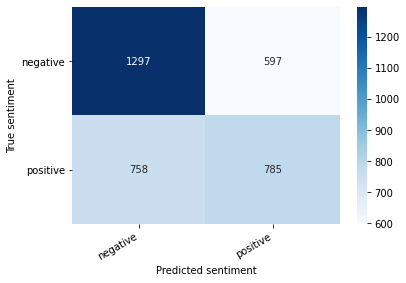

In [47]:
# run SVM on 2 classes sentiment label
svm_classifier = svm.SVC(kernel='linear')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', svm_classifier)])
pipe.fit(X_train_2classes, y_train_2classes)

# Predicting with a test dataset
predicted = pipe.predict(X_test_2classes)

class_names = ['negative', 'positive']
print(classification_report(y_test_2classes, predicted, target_names=class_names))

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test_2classes, predicted)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Fitting 4 folds for each of 648 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 61.4min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 64.8min finished


{'classifier__C': 1.0,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'rbf',
 'vectorizer__max_df': 10,
 'vectorizer__min_df': 4}

              precision    recall  f1-score   support

    negative       0.58      0.74      0.65      1894
    positive       0.52      0.35      0.42      1543

    accuracy                           0.56      3437
   macro avg       0.55      0.54      0.53      3437
weighted avg       0.55      0.56      0.54      3437



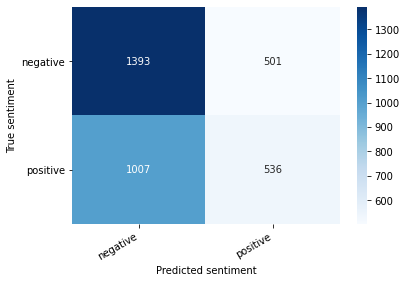

In [55]:
# run SVM optimization on 2 classes sentiment label
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', svm.SVC(kernel='linear'))]) 

parameters= {
    'vectorizer__max_df': [8,10,14],
    'vectorizer__min_df': [2,4,6],
    'classifier__C':  [0.1, 1.0, 10,100],
    'classifier__gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid'],

}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)


# define and evaluate a random search
grid_search_estimator = GridSearchCV(pipe, parameters, scoring='accuracy', cv=cv, return_train_score=True, verbose =1, n_jobs = -1)#model-selection


grid_search_estimator.fit(X_train_2classes, y_train_2classes)
display(grid_search_estimator.best_params_)
clf = grid_search_estimator.best_estimator_
predicted = clf.predict(X_test_2classes)


class_names = ['negative','positive']
print(classification_report(y_test_2classes, predicted, target_names=class_names))
cm = confusion_matrix(y_test_2classes, predicted)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


## Multiple Classifier Comparison

Fitting 4 folds for each of 150 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 24.3min finished


{'vectorizer__selected_model': ('cnt',
  {'binary': False, 'max_df': 10.0, 'min_df': 6}),
 'classifier__selected_model': ('rf',
  {'bootstrap': False,
   'max_depth': None,
   'max_features': 'sqrt',
   'min_samples_leaf': 2,
   'min_samples_split': 5,
   'n_estimators': 800})}

              precision    recall  f1-score   support

    negative       0.64      0.74      0.69      1894
    positive       0.61      0.50      0.55      1543

    accuracy                           0.63      3437
   macro avg       0.63      0.62      0.62      3437
weighted avg       0.63      0.63      0.62      3437



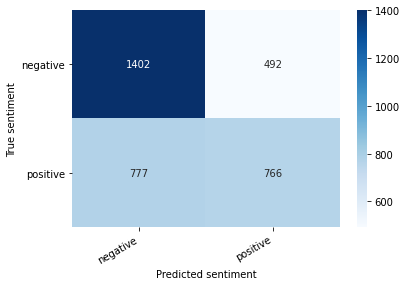

In [52]:
#cv
pipe = Pipeline([
    ('vectorizer', PipelineHelper([
        ('tfidf', TfidfVectorizer()),
        ('cnt', CountVectorizer()),
    ])),
    ('classifier', PipelineHelper([
        ('mnb', MultinomialNB()),
        ('sgd' , SGDClassifier()),
        ('svm', svm.SVC()),
        ('rf', RandomForestClassifier()),
        ('xgb', XGBClassifier()),
    ])),
])

parameters = {
    'vectorizer__selected_model': pipe.named_steps['vectorizer'].generate({
        'tfidf__max_df': [10,35],
        'tfidf__min_df': [2,4,8],
        #'tfidf__use_idf':[True,False],
        'cnt__max_df':np.linspace(10,30,5),
        'cnt__min_df':[4,6,8],
        'cnt__binary': [True,False],
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'mnb__alpha': np.linspace(0.5, 1.5, 4),
        'mnb__fit_prior': [True, False],
        'sgd__loss':  ["hinge", "log", "squared_loss", "huber", "squared_hinge", "modified_huber"],
        'sgd__penalty':  ["l2", "l1", "none","elasticnet"], 
        'sgd__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1], 
        #'sgd__learning_rate':['constant', 'optimal', 'invscaling'],
        'sgd__class_weight' :[{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
        'svm__C': [0.01,0.1,1,10,100], 
        'svm__gamma': [1,0.1,0.01,0.001],
        'svm__kernel': ['rbf', 'poly', 'sigmoid'],
        'rf__bootstrap': [True, False],
        'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__min_samples_split': [2, 5, 10],
        'rf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
        'xgb__n_estimators':range(162,188,4),
        'xgb__max_depth':range(4,8,1), 
        'xgb__learning_rate':np.linspace(0.1,0.3,10), 
        'xgb__subsample':np.linspace(0.7,0.9,10),
        'xgb__colsample_bytree':np.linspace(0.5,0.7,10),  
        'xgb__classification__min_child_weight':range(1,4,1)
    })
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

# # define the cross-validation splits for the nested CV
# nested_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# define and evaluate a grid search
random_search_estimator = RandomizedSearchCV(pipe, parameters, scoring='accuracy', cv=cv,n_iter=150, return_train_score=True, verbose =1, n_jobs = -1)#model-selection

# # run the random search
# accuracy_optimal = cross_val_score(random_search_estimator, X,ylabels_3classes, cv=cv, scoring='accuracy', verbose =1, n_jobs=-1)#model-evaluation
# print("Optimal cross-validated accuracy: {}%".format(accuracy_optimal.mean() * 100.0))


random_search_estimator.fit(X_train_2classes, y_train_2classes)
display(random_search_estimator.best_params_)
clf = random_search_estimator.best_estimator_
predicted = clf.predict(X_test_2classes)


class_names = ['negative', 'positive']
print(classification_report(y_test_2classes, predicted, target_names=class_names))
cm = confusion_matrix(y_test_2classes, predicted)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)



# 3-Classes Classification

## SVM Classifier

In [16]:
# Splitting The Data into Training, Validation and Test Sets
X = df['Corpus']
ylabels_3classes = np.array(list(df['sentiment_3classes']))    

X_train, X_test, y_train_3classes, y_test_3classes = train_test_split(X, ylabels_3classes, test_size=0.3, random_state=RANDOM_SEED, shuffle=True)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)
#print(len(X_train), len(X_val), len(X_test))
print(len(X_train), len(X_test),len(y_train_3classes), len(y_test_3classes))

8028 3441 8028 3441


SVM Accuracy: 0.44086021505376344
              precision    recall  f1-score   support

    negative       0.47      0.64      0.54      1374
     neutral       0.30      0.19      0.23       957
    positive       0.47      0.41      0.44      1110

    accuracy                           0.44      3441
   macro avg       0.41      0.41      0.40      3441
weighted avg       0.42      0.44      0.42      3441



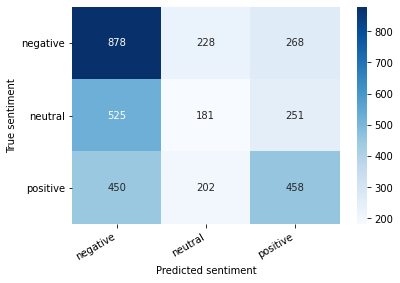

In [20]:
# Text Vectorizer
bow_vector = CountVectorizer()
tfidf_vector = TfidfVectorizer()
# run SVM on 2 classes sentiment label
svm_classifier = svm.SVC(kernel='linear')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', svm_classifier)])
pipe.fit(X_train, y_train_3classes)

# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("SVM Accuracy:",metrics.accuracy_score(y_test_3classes, predicted))

class_names = ['negative','neutral', 'positive']
print(classification_report(y_test_3classes, predicted, target_names=class_names))

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test_3classes, predicted)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.8min finished


{'vectorizer__min_df': 2,
 'vectorizer__max_df': 35,
 'classifier__kernel': 'rbf',
 'classifier__gamma': 1,
 'classifier__C': 1}

              precision    recall  f1-score   support

    negative       0.43      0.76      0.55      1374
     neutral       0.33      0.14      0.20       957
    positive       0.44      0.24      0.31      1110

    accuracy                           0.42      3441
   macro avg       0.40      0.38      0.35      3441
weighted avg       0.41      0.42      0.37      3441



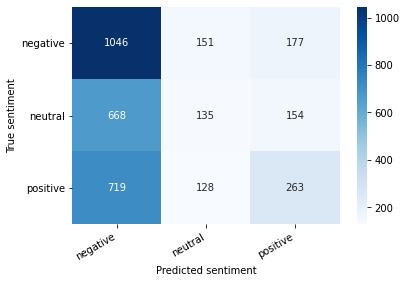

In [28]:
# run SVM optimization on 3 classes sentiment label
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', svm.SVC(kernel='linear'))]) 

parameters= {
    'vectorizer__max_df': [10,35],
    'vectorizer__min_df': [2,4,8],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__gamma': [1,0.1,0.01,0.001],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid'],

}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)


# define and evaluate a random search
random_search_estimator = RandomizedSearchCV(pipe, parameters, scoring='accuracy', cv=cv,n_iter=20, return_train_score=True, verbose =1, n_jobs = -1)#model-selection


random_search_estimator.fit(X_train, y_train_3classes)
display(random_search_estimator.best_params_)
clf = random_search_estimator.best_estimator_
predicted = clf.predict(X_test)


class_names = ['negative','neutral', 'positive']
print(classification_report(y_test_3classes, predicted, target_names=class_names))
cm = confusion_matrix(y_test_3classes, predicted)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


## Multiple Classifier Comparison

Fitting 4 folds for each of 150 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 47.1min finished


{'vectorizer__selected_model': ('cnt',
  {'binary': False, 'max_df': 30.0, 'min_df': 4}),
 'classifier__selected_model': ('rf',
  {'bootstrap': True,
   'max_depth': None,
   'max_features': 'sqrt',
   'min_samples_leaf': 1,
   'min_samples_split': 10,
   'n_estimators': 1400})}

              precision    recall  f1-score   support

    negative       0.49      0.82      0.61      1374
     neutral       0.52      0.06      0.11       957
    positive       0.51      0.47      0.49      1110

    accuracy                           0.50      3441
   macro avg       0.51      0.45      0.40      3441
weighted avg       0.51      0.50      0.43      3441



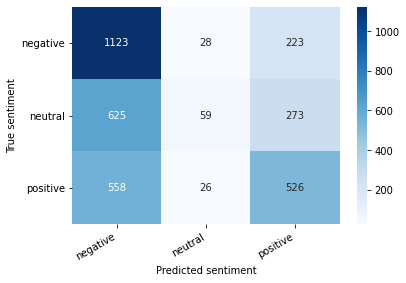

In [30]:
#cv
pipe = Pipeline([
    ('vectorizer', PipelineHelper([
        ('tfidf', TfidfVectorizer()),
        ('cnt', CountVectorizer()),
    ])),
    ('classifier', PipelineHelper([
        ('mnb', MultinomialNB()),
        ('sgd' , SGDClassifier()),
        ('svm', svm.SVC()),
        ('rf', RandomForestClassifier()),
        ('xgb', XGBClassifier()),
    ])),
])

parameters = {
    'vectorizer__selected_model': pipe.named_steps['vectorizer'].generate({
        'tfidf__max_df': [10,35],
        'tfidf__min_df': [2,4,8],
        #'tfidf__use_idf':[True,False],
        'cnt__max_df':np.linspace(10,30,5),
        'cnt__min_df':[4,6,8],
        'cnt__binary': [True,False],
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'mnb__alpha': np.linspace(0.5, 1.5, 4),
        'mnb__fit_prior': [True, False],
        'sgd__loss':  ["hinge", "log", "squared_loss", "huber", "squared_hinge", "modified_huber"],
        'sgd__penalty':  ["l2", "l1", "none","elasticnet"], 
        'sgd__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1], 
        #'sgd__learning_rate':['constant', 'optimal', 'invscaling'],
        'sgd__class_weight' :[{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
        'svm__C': [0.01,0.1,1,10,100], 
        'svm__gamma': [1,0.1,0.01,0.001],
        'svm__kernel': ['rbf', 'poly', 'sigmoid'],
        'rf__bootstrap': [True, False],
        'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__min_samples_split': [2, 5, 10],
        'rf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
        'xgb__n_estimators':range(162,188,4),
        'xgb__max_depth':range(4,8,1), 
        'xgb__learning_rate':np.linspace(0.1,0.3,10), 
        'xgb__subsample':np.linspace(0.7,0.9,10),
        'xgb__colsample_bytree':np.linspace(0.5,0.7,10),  
        'xgb__classification__min_child_weight':range(1,4,1)
    })
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

# # define the cross-validation splits for the nested CV
# nested_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# define and evaluate a grid search
random_search_estimator = RandomizedSearchCV(pipe, parameters, scoring='accuracy', cv=cv,n_iter=150, return_train_score=True, verbose =1, n_jobs = -1)#model-selection

# # run the random search
# accuracy_optimal = cross_val_score(random_search_estimator, X,ylabels_3classes, cv=cv, scoring='accuracy', verbose =1, n_jobs=-1)#model-evaluation
# print("Optimal cross-validated accuracy: {}%".format(accuracy_optimal.mean() * 100.0))


random_search_estimator.fit(X_train, y_train_3classes)
display(random_search_estimator.best_params_)
clf = random_search_estimator.best_estimator_
predicted = clf.predict(X_test)


class_names = ['negative','neutral', 'positive']
print(classification_report(y_test_3classes, predicted, target_names=class_names))
cm = confusion_matrix(y_test_3classes, predicted)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

